In [287]:
import numpy as np
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy import stats

# Set precision to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [288]:
def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> Dict[int, pd.DataFrame]:
    """
    Reads Parquet files for specified years from the input directory.

    Args:
        input_dir (str): The directory where Parquet files are stored.
        years (Optional[List[int]]): A list of years to read. If None, read all available years.

    Returns:
        Dict[int, pd.DataFrame]: A dictionary with years as keys and pandas DataFrames as values.
    """
    data_frames = {}
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)
            df['year'] = year  # Add the year column 
            data_frames[year] = df
        else:
            print(f"Warning: No data found for year {year}")

    return data_frames

### EDA

In [289]:
years = [2015, 2016, 2017, 2018, 2019] 
output_directory = "../data/DS/NSDUH"

# Read saved data 
df = pd.concat(read_parquet(output_directory, years).values())   
        

In [290]:
shape = df.shape
missing_values = df.isnull().sum().sum()
print("Shape:", shape)
print("Missing Values:\n", missing_values)

Shape: (282768, 2814)
Missing Values:
 105689499


In [291]:
# Create a summary DataFrame with data types and unique counts
summary_df = pd.DataFrame({
    'Data Type': df.dtypes,
    'Non-null Count': df.notnull().sum(),
    'Unique Count': df.nunique()
})

# Display the summary DataFrame
print(summary_df)


          Data Type  Non-null Count  Unique Count
QUESTID2      int64          282768        277519
FILEDATE     object          282768             5
CIGEVER       int64          282768             2
CIGOFRSM      int64          282768             9
CIGWILYR      int64          282768            10
...             ...             ...           ...
OPMEDYR2    float64           56136             2
ALOPMEDYR   float64           56136             2
KRATFLG     float64           56136             2
KRATYR      float64           56136             2
KRATMON     float64           56136             2

[2814 rows x 3 columns]


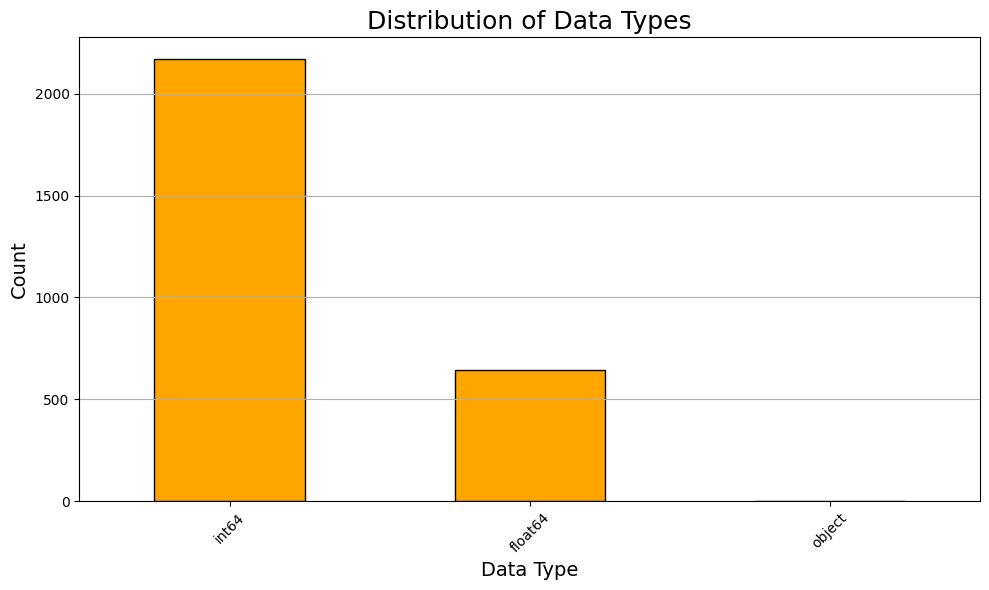

In [292]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_data_type_distribution(df: pd.DataFrame) -> None:
    """
    Plots a bar graph showing the distribution of different data types in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    """
    # Count the occurrences of each data type
    data_type_counts = df.dtypes.value_counts()

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    data_type_counts.plot(kind='bar', color='orange', edgecolor='black')
    plt.title('Distribution of Data Types', fontsize=18)
    plt.xlabel('Data Type', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45)  # Rotate x labels for better readability
    plt.grid(axis='y')  # Add grid lines for better readability
    plt.tight_layout()  # Adjust layout for better fit
    plt.show()

# Example usage
# df = pd.read_csv('your_data.csv')  # Load your dataset
plot_data_type_distribution(df)


In [293]:
# Get only object (string) columns
object_cols = df.select_dtypes(include='object')
print("Object Columns:")
print(object_cols.columns)

Object Columns:
Index(['FILEDATE', 'GQTYPE2'], dtype='object')


In [294]:
df['GQTYPE2'].unique()

array(['O', None, 'C'], dtype=object)

In [295]:
# Calculate the percentage of zero values for each column
zero_percentage = (df == 0).mean()

# Define a threshold for sparsity, e.g., 80% zero values
sparsity_threshold = 0.8

# Identify sparse columns based on zero values
sparse_zero_columns = zero_percentage[zero_percentage > sparsity_threshold].index.tolist()

# Combine all sparse columns
sparse_columns = list(set(sparse_zero_columns))

print("Sparse Columns:", sparse_columns)

Sparse Columns: ['ABUSEPYINH', 'TXYRSLFAL', 'PSYCHFLAG', 'ECSTMOFLAG', 'OXYMPDAPYU', 'CYCLPDPYMU', 'TXLTYCOCN2', 'SOLVENT2', 'DEPNDPYIEM', 'BUPRPDPYMU', 'ZALEPDAPYU', 'DEPNDPYMTH', 'TXPDCOURIL', 'PNRNMYR', 'ALPRPDPYMU', 'OPINMYR', 'TXYRRESOV2', 'ABUSEMRJ', 'TXPDHINSIL', 'TXYRSLFHP2', 'TXLTYSEDV2', 'ESZOPDAPYU', 'TXPDMCADIL', 'DEPNDMRJ', 'PROVPDPYMU', 'UDPYPNR', 'TXYRILL', 'NDSSDNSP', 'TXLTYTRQL2', 'ABUSECOC', 'DEPNDHER', 'TXYRILANAL', 'CRKFLAG', 'MTDNPDAPYU', 'ABUSEPYPNR', 'TXLTCURRSP', 'TXYRNDILL', 'GLUE2', 'MUSRLXPYMU', 'HALLUCMON', 'OXYCNANYYR', 'STMNMYR', 'ABODCOC', 'CRKMON', 'GHBFLGR', 'SALVIAFLAG', 'GAS2', 'CYCLPDAPYU', 'TXLTYSTIM2', 'SEDOTHPYMU2', 'MORPPDAPYU', 'UDPYILL', 'STMNMFLAG', 'DIFOBTLSD', 'COLDYRR', 'UDPYTRQ', 'HVYDRKMON', 'CLEFLU2', 'LGAS2', 'TXPAYHINS2', 'HERSMOK2', 'TRQNMYR', 'PNRNMFLAG', 'TXYRRECVD2', 'MUSRLXAPYU', 'ALPRPDAPYU', 'TXLTYILL', 'TXYREMRAL', 'ABODMRJ', 'HYDMPDAPYU', 'MRJYR', 'UDPYOPI', 'DEMEPDPYMU', 'TXPDBOSSAL', 'DEPNDPYSED', 'TXYRALNIL', 'PIPMON', 'TXL

In [296]:
# Identify columns with only one unique non-NaN value
single_unique_columns = [col for col in df.columns if df[col].nunique(dropna=True) == 1]

print("Columns with One Unique Non-NaN Value:", single_unique_columns)

Columns with One Unique Non-NaN Value: []


In [297]:
# Identify columns with exactly two unique non-NaN values
two_unique_columns = [col for col in df.columns if df[col].nunique(dropna=True) == 2]

print("Number of Columns with two Unique Non-NaN Value:", len(two_unique_columns))

# Print the columns and their unique values
for col in two_unique_columns:
    unique_values = df[col].dropna().unique()
    # Unccoment to see all the columns
    # print(f"Column: {col}, Unique Values: {unique_values}")






Number of Columns with two Unique Non-NaN Value: 780


In [298]:
# Define a dictionary for replacements based on the code conventions
code_replacements = {
    91: 'Never Used',
    991: 'Never Used',
    9991: 'Never Used',
    93: 'Used Not in Period',
    993: 'Used Not in Period',
    9993: 'Used Not in Period',
    94: np.nan,  # Don't Know
    994: np.nan,
    9994: np.nan,
    97: np.nan,  # Refused
    997: np.nan,
    9997: np.nan,
    98: np.nan,  # Blank
    998: np.nan,
    9998: np.nan,
    99: np.nan,  # Legitimate Skip
    999: np.nan,
    9999: np.nan
}

# Apply the replacements to the DataFrame
df_temp = df.replace(code_replacements)

# Verify changes
print(df_temp.head())

   QUESTID2    FILEDATE  CIGEVER  CIGOFRSM  CIGWILYR      CIGTRY      CIGYFU  \
0  25095143  02/15/2018        1       NaN       NaN          16        2014   
1  13005143  02/15/2018        1       NaN       NaN          15         NaN   
2  67415143  02/15/2018        2       NaN       NaN  Never Used  Never Used   
3  70925143  02/15/2018        2      3.00      4.00  Never Used  Never Used   
4  75235143  02/15/2018        1       NaN       NaN          17         NaN   

       CIGMFU      CIGREC            CIG30USE  ... CASUPROB2 RCVYSUBPRB  \
0           1           2  Used Not in Period  ...       NaN        NaN   
1         NaN           3  Used Not in Period  ...       NaN        NaN   
2  Never Used  Never Used          Never Used  ...       NaN        NaN   
3  Never Used  Never Used          Never Used  ...       NaN        NaN   
4         NaN           1                  22  ...       NaN        NaN   

  CAMHPROB2 RCVYMHPRB ALMEDYR2 OPMEDYR2 ALOPMEDYR KRATFLG KRATYR KRA

In [299]:
df.describe()

,QUESTID2,CIGEVER,CIGOFRSM,CIGWILYR,CIGTRY,CIGYFU,CIGMFU,CIGREC,CIG30USE,CG30EST,...,CASUPROB2,RCVYSUBPRB,CAMHPROB2,RCVYMHPRB,ALMEDYR2,OPMEDYR2,ALOPMEDYR,KRATFLG,KRATYR,KRATMON
count,282768.00,282768.00,282768.00,282768.00,282768.00,282768.00,282768.00,282768.00,282768.00,282768.00,...,42383.00,42361.00,42394.00,42316.00,56136.00,56136.00,56136.00,56136.00,56136.00,56136.00
mean,54378713.00,1.52,78.76,78.77,527.12,9825.70,92.95,48.48,79.00,92.93,...,0.11,0.08,0.24,0.16,0.00,0.00,0.00,0.02,0.01,0.00
std,25557835.04,0.50,38.94,38.92,486.98,1148.80,12.88,44.13,27.70,4.34,...,0.31,0.27,0.43,0.37,0.03,0.05,0.06,0.13,0.09,0.06
min,10000608.00,1.00,1.00,1.00,1.00,2013.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,32135244.00,1.00,99.00,99.00,16.00,9991.00,91.00,3.00,91.00,91.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,54106740.00,2.00,99.00,99.00,991.00,9991.00,91.00,91.00,91.00,91.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,76090466.50,2.00,99.00,99.00,991.00,9999.00,99.00,91.00,93.00,93.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,99999998.00,2.00,99.00,99.00,997.00,9999.00,99.00,91.00,98.00,99.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


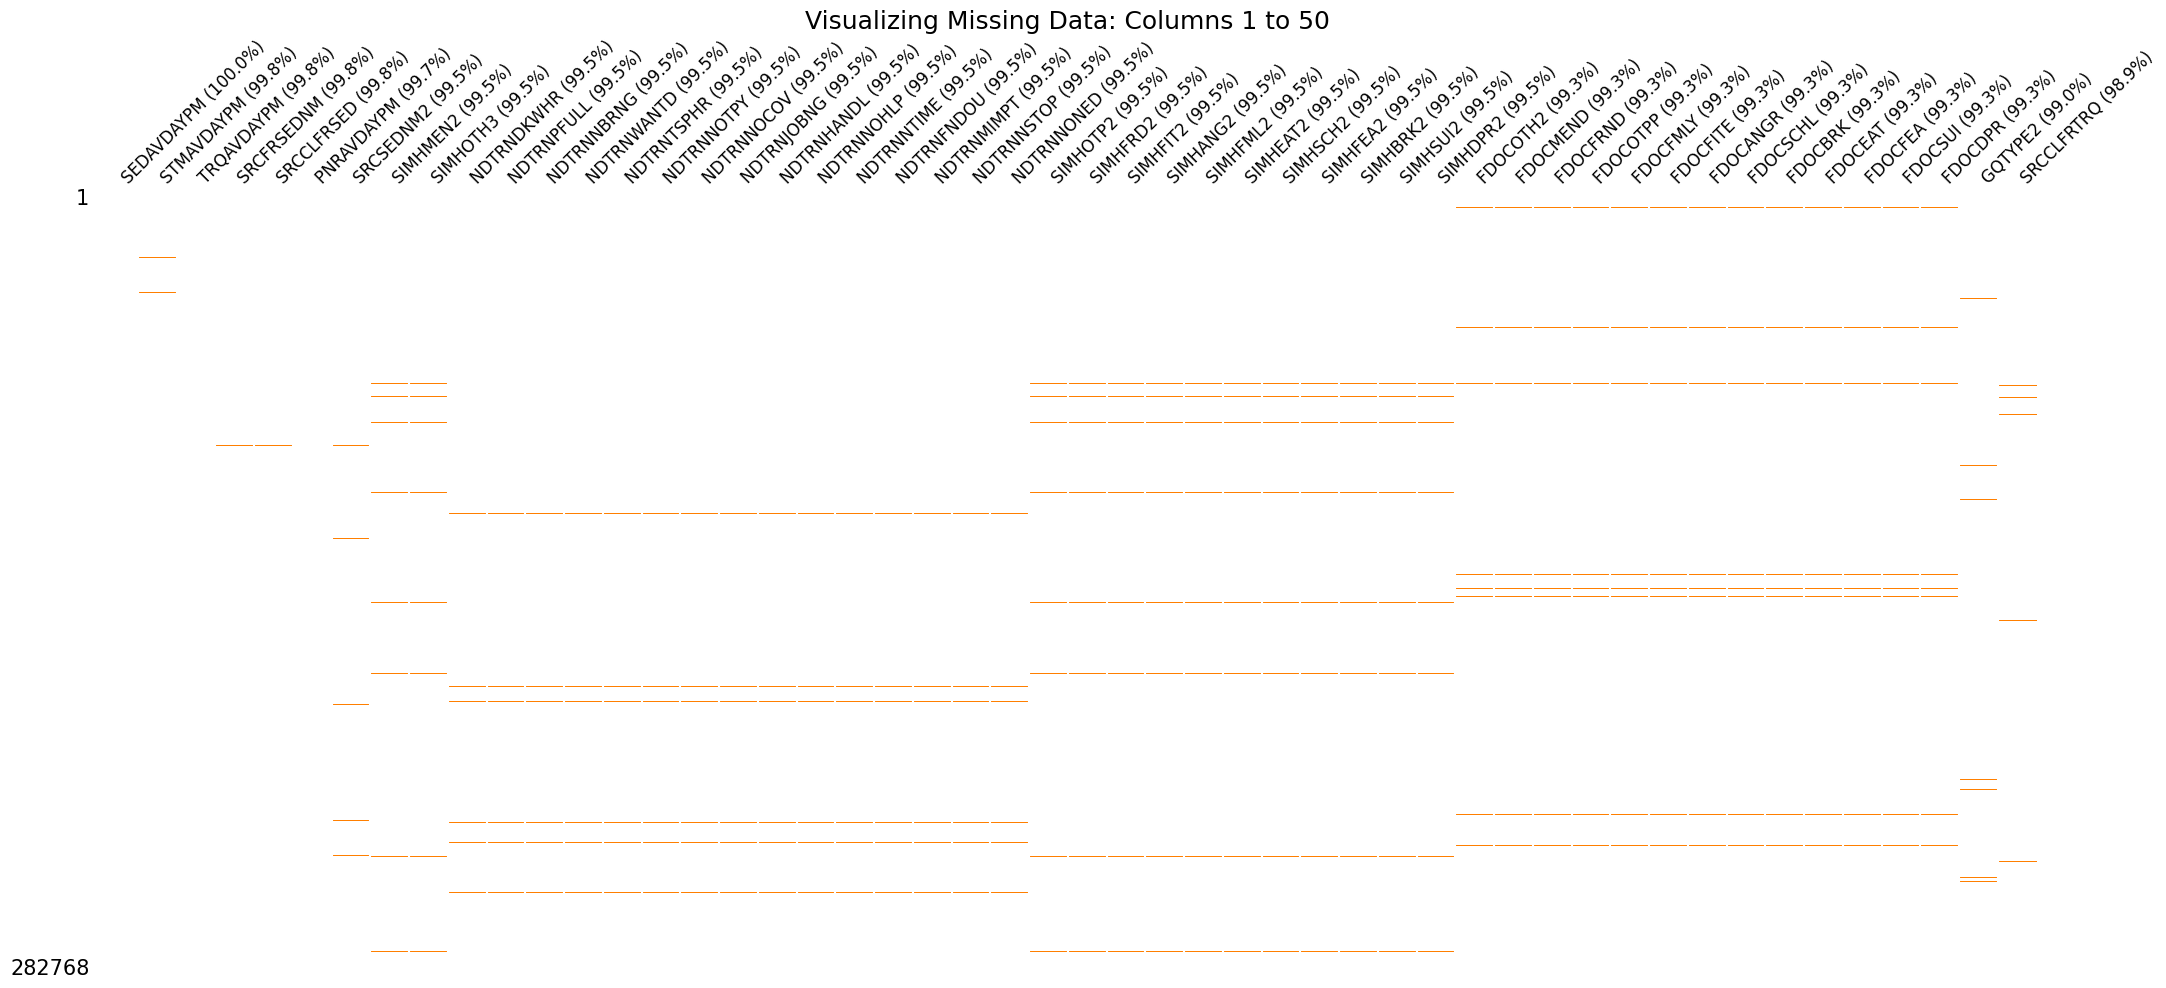

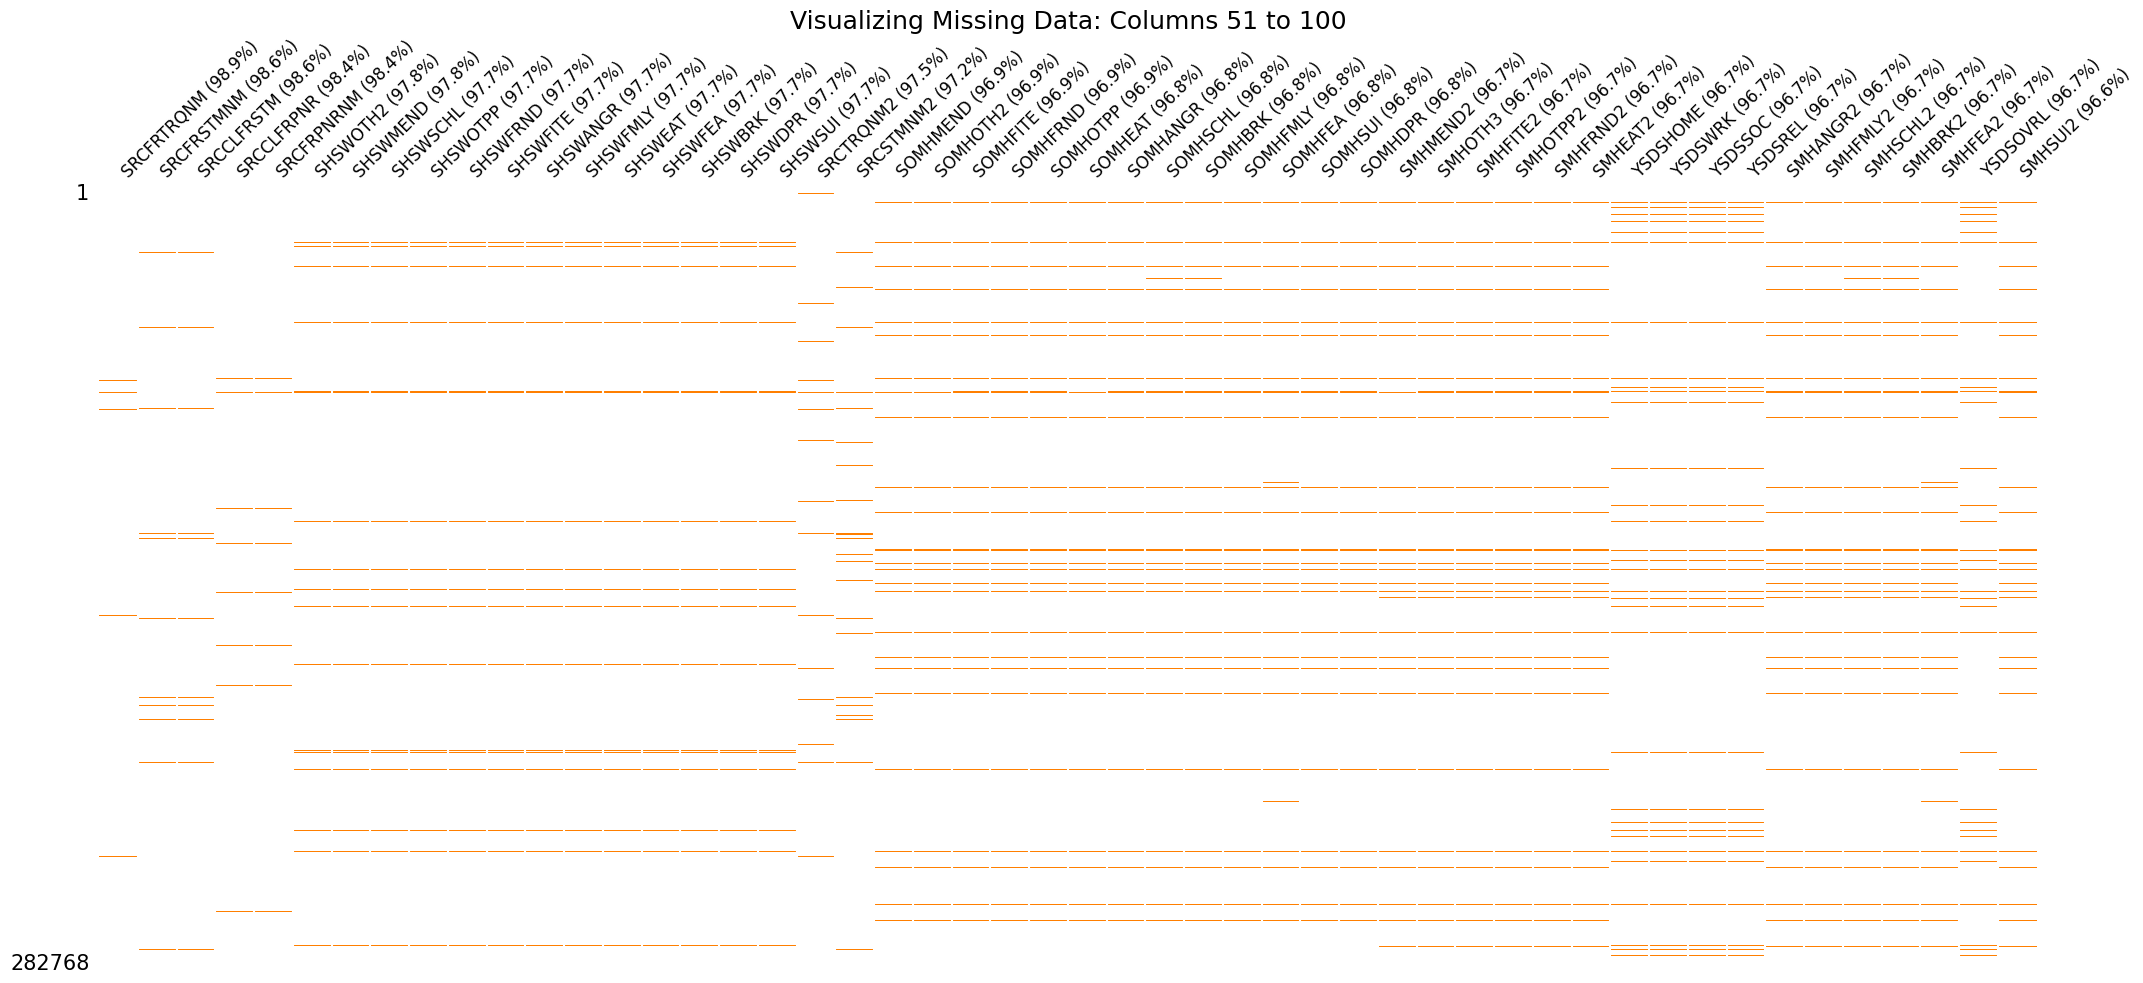

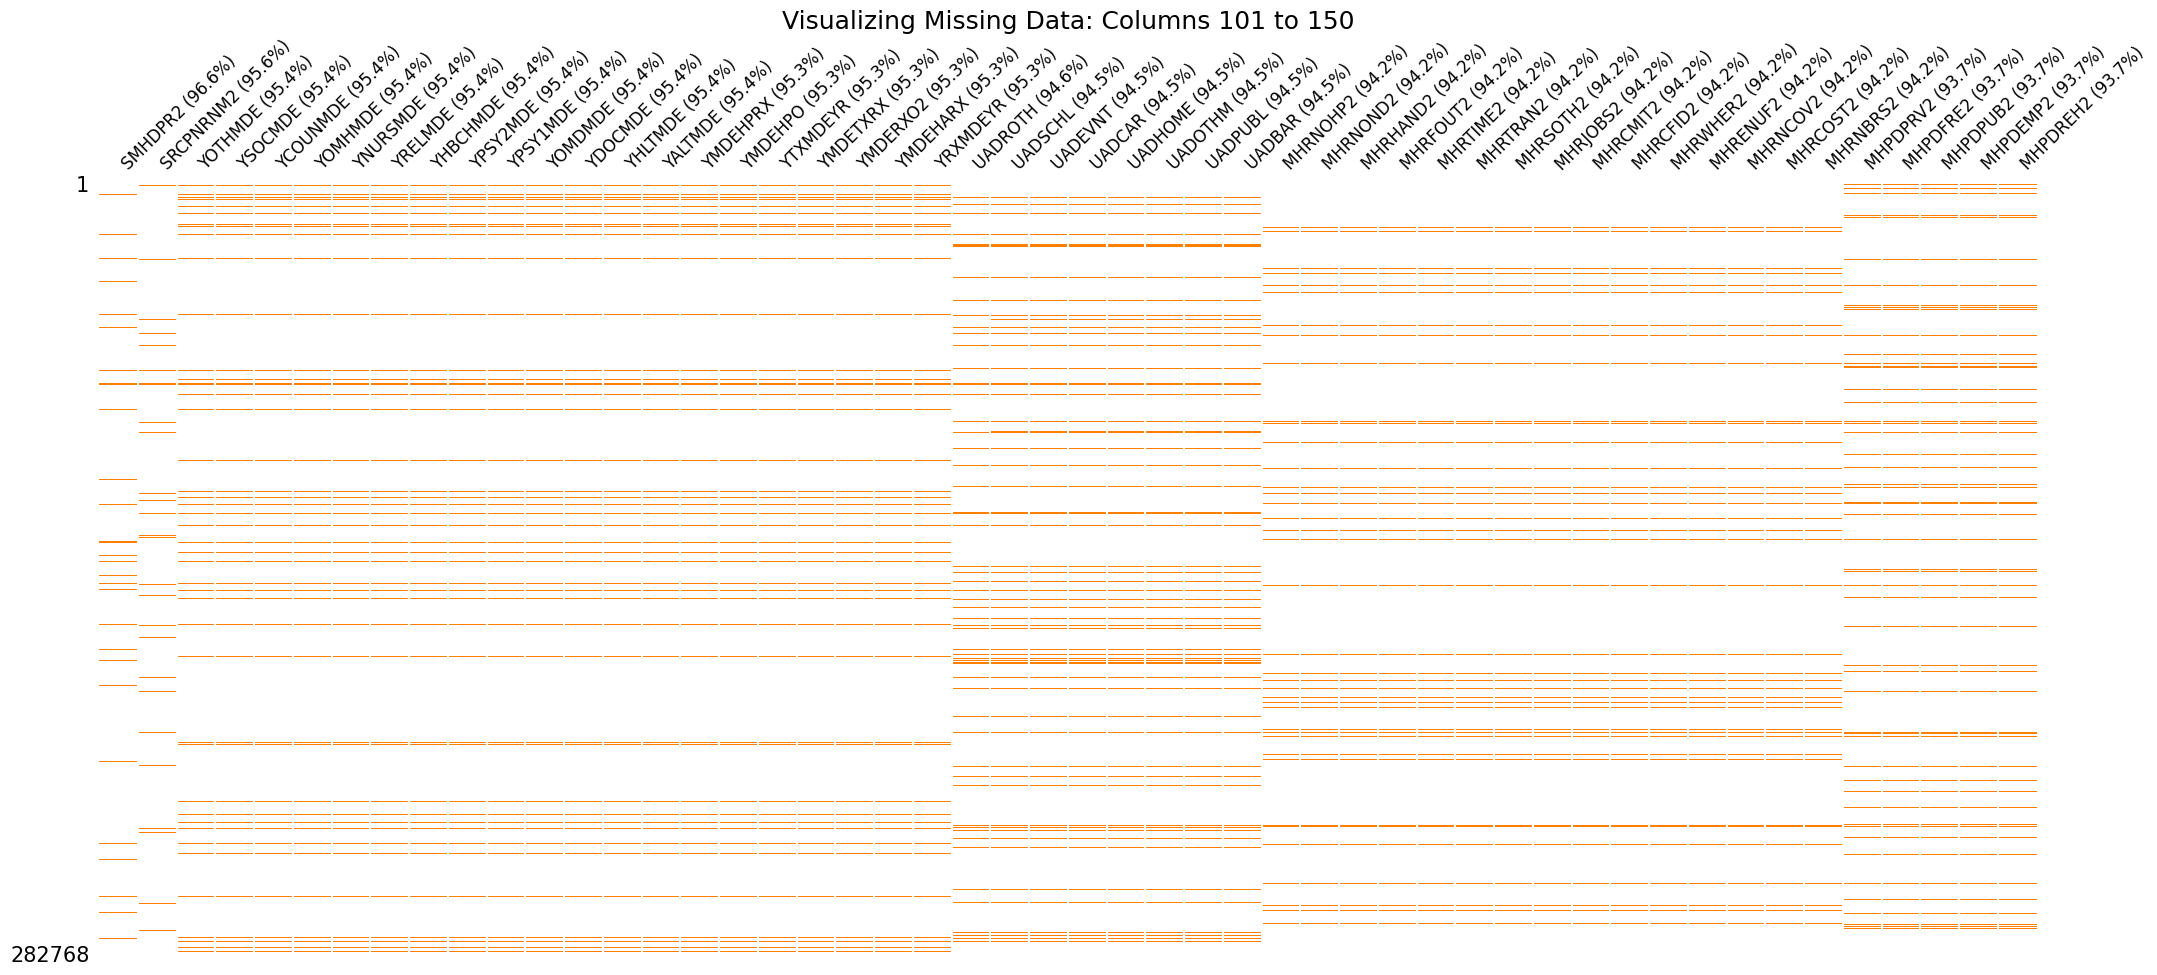

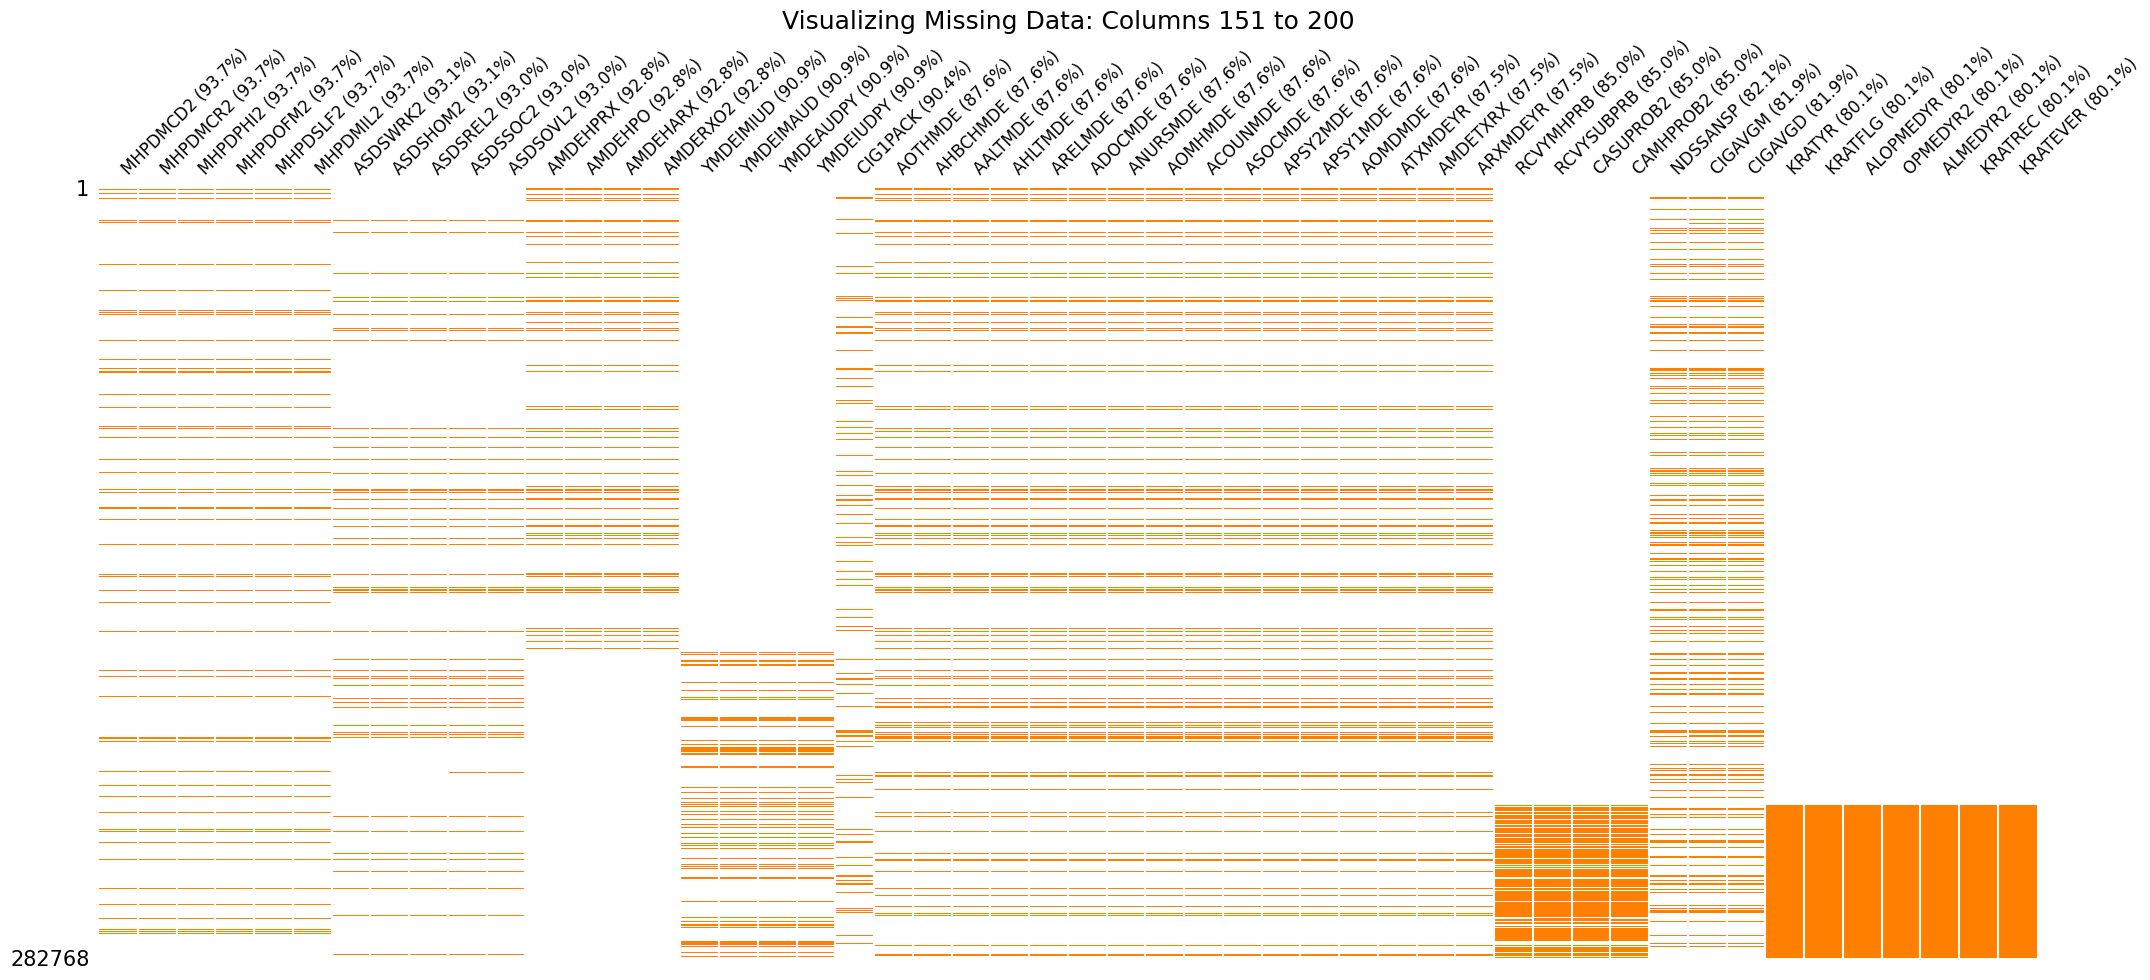

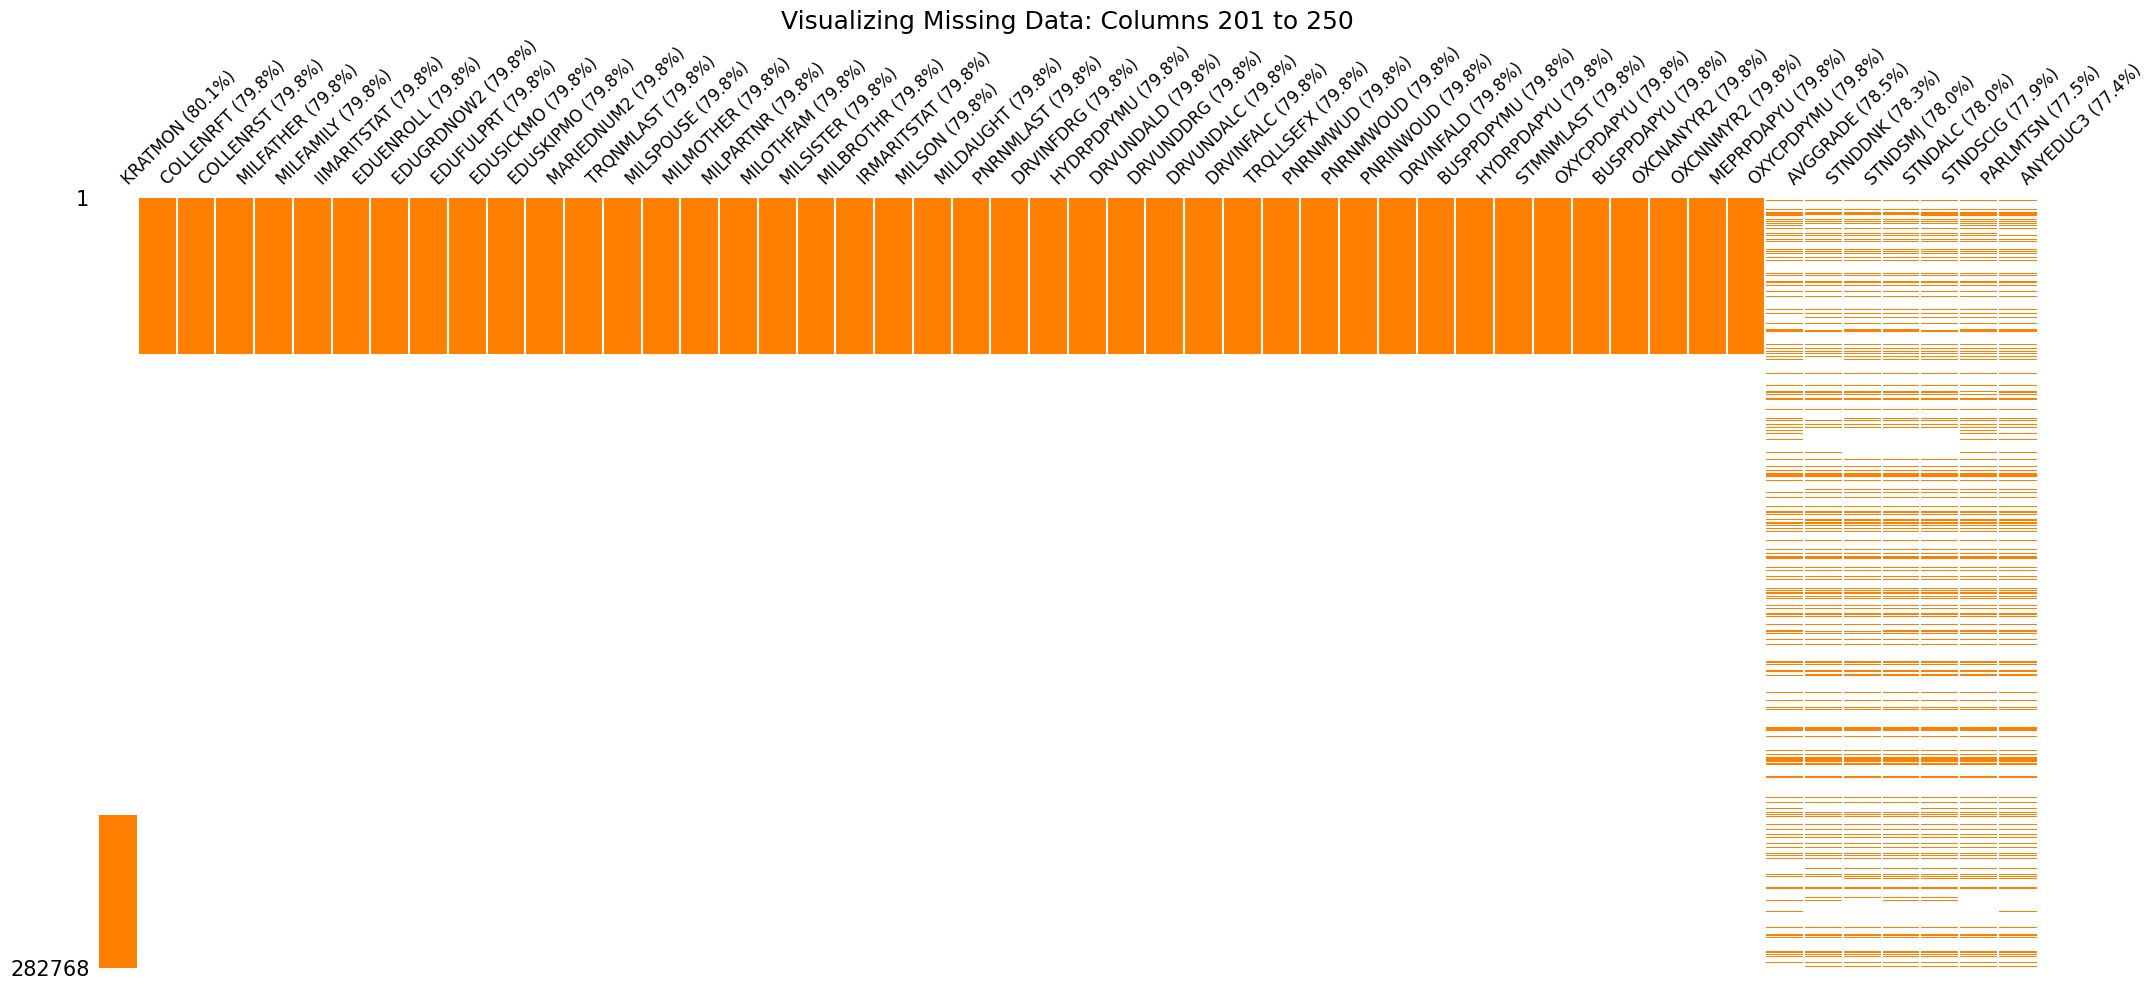

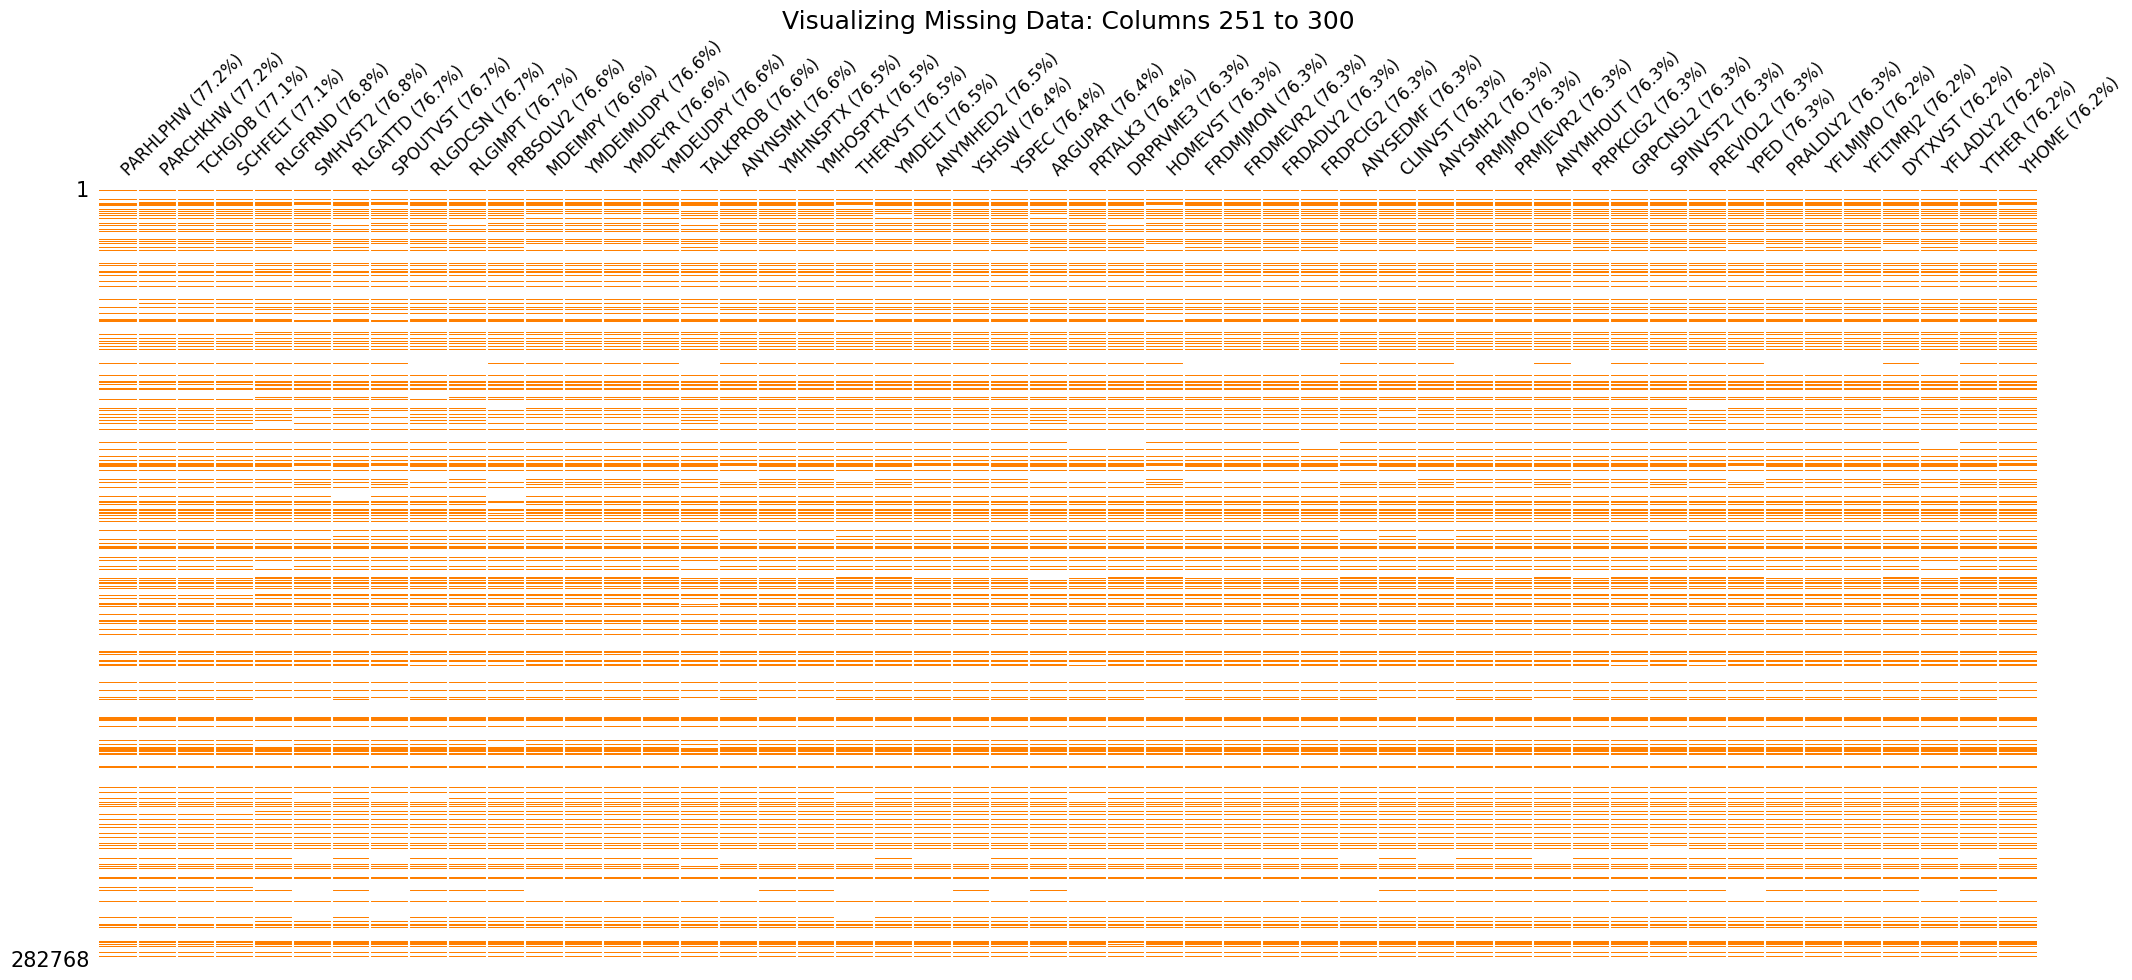

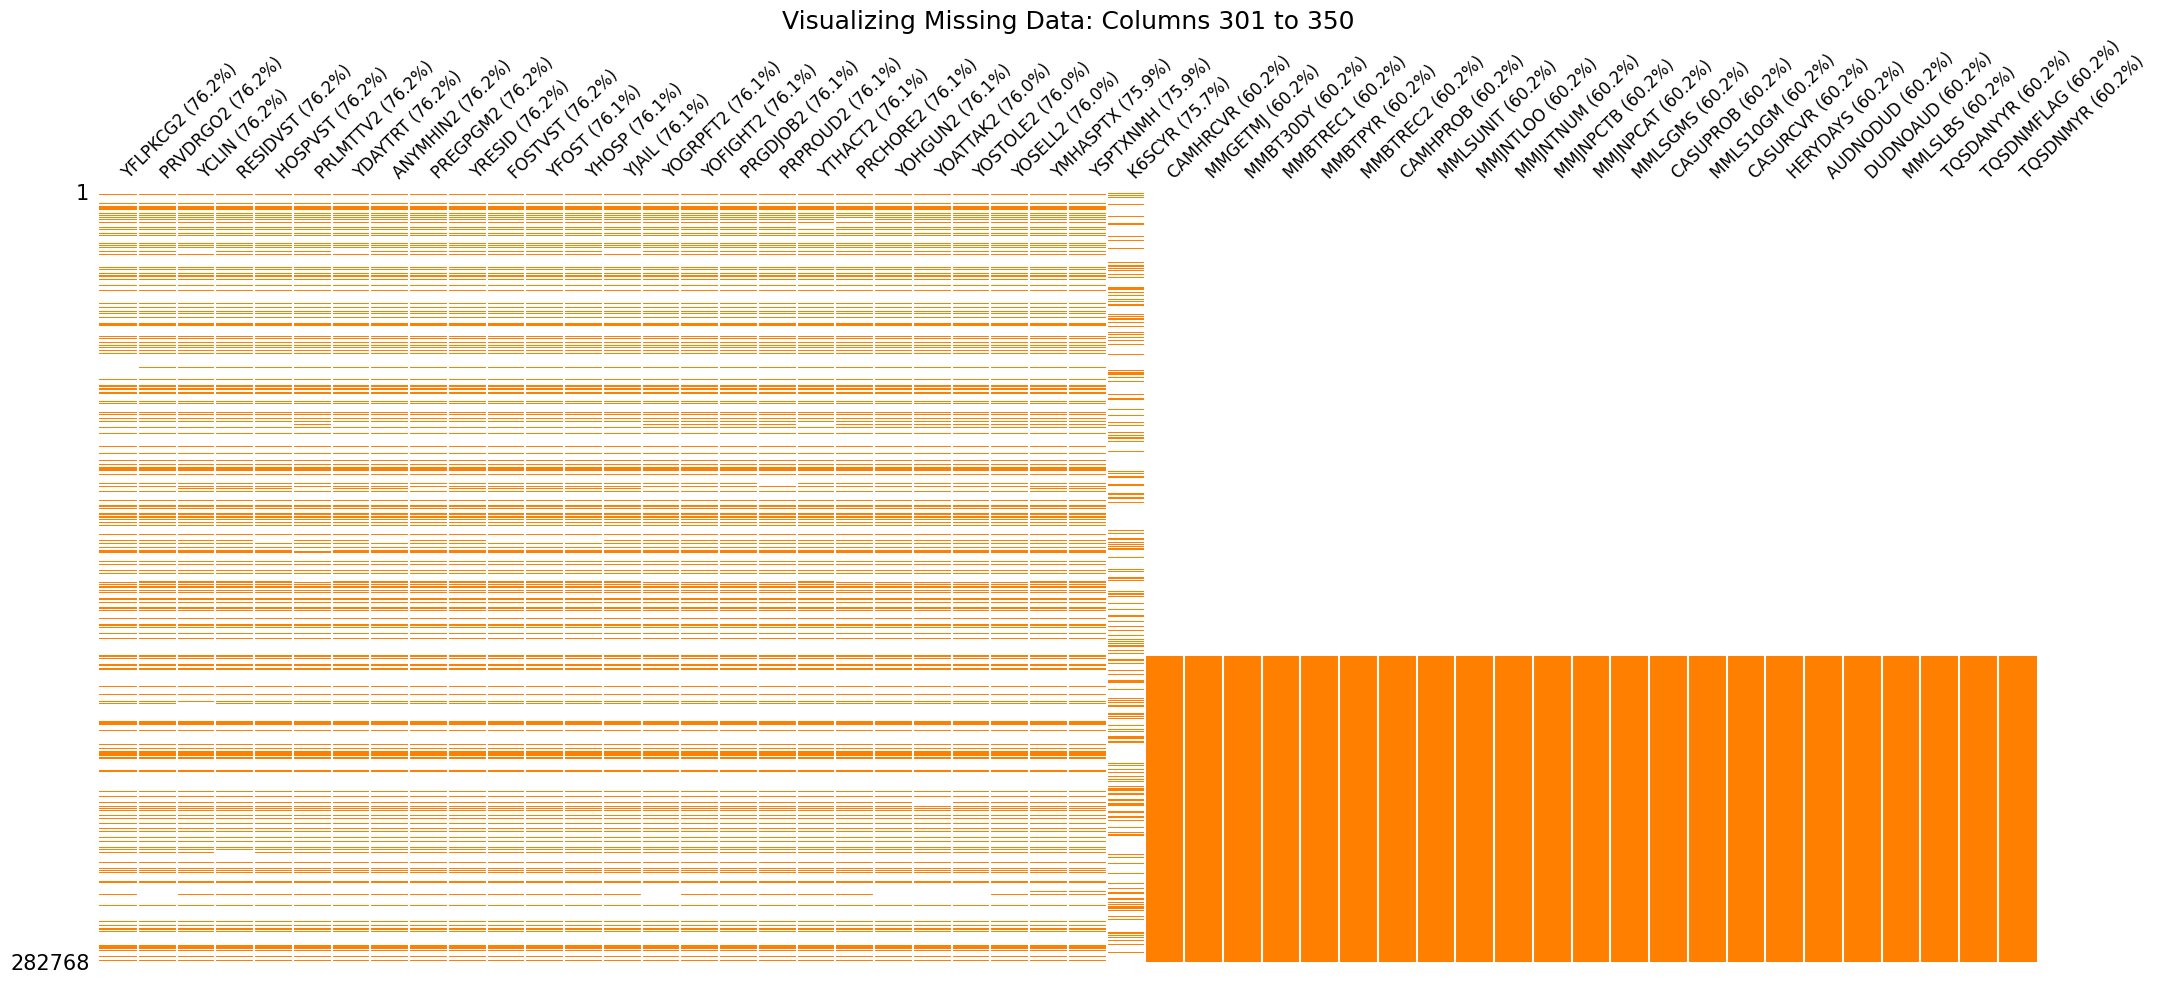

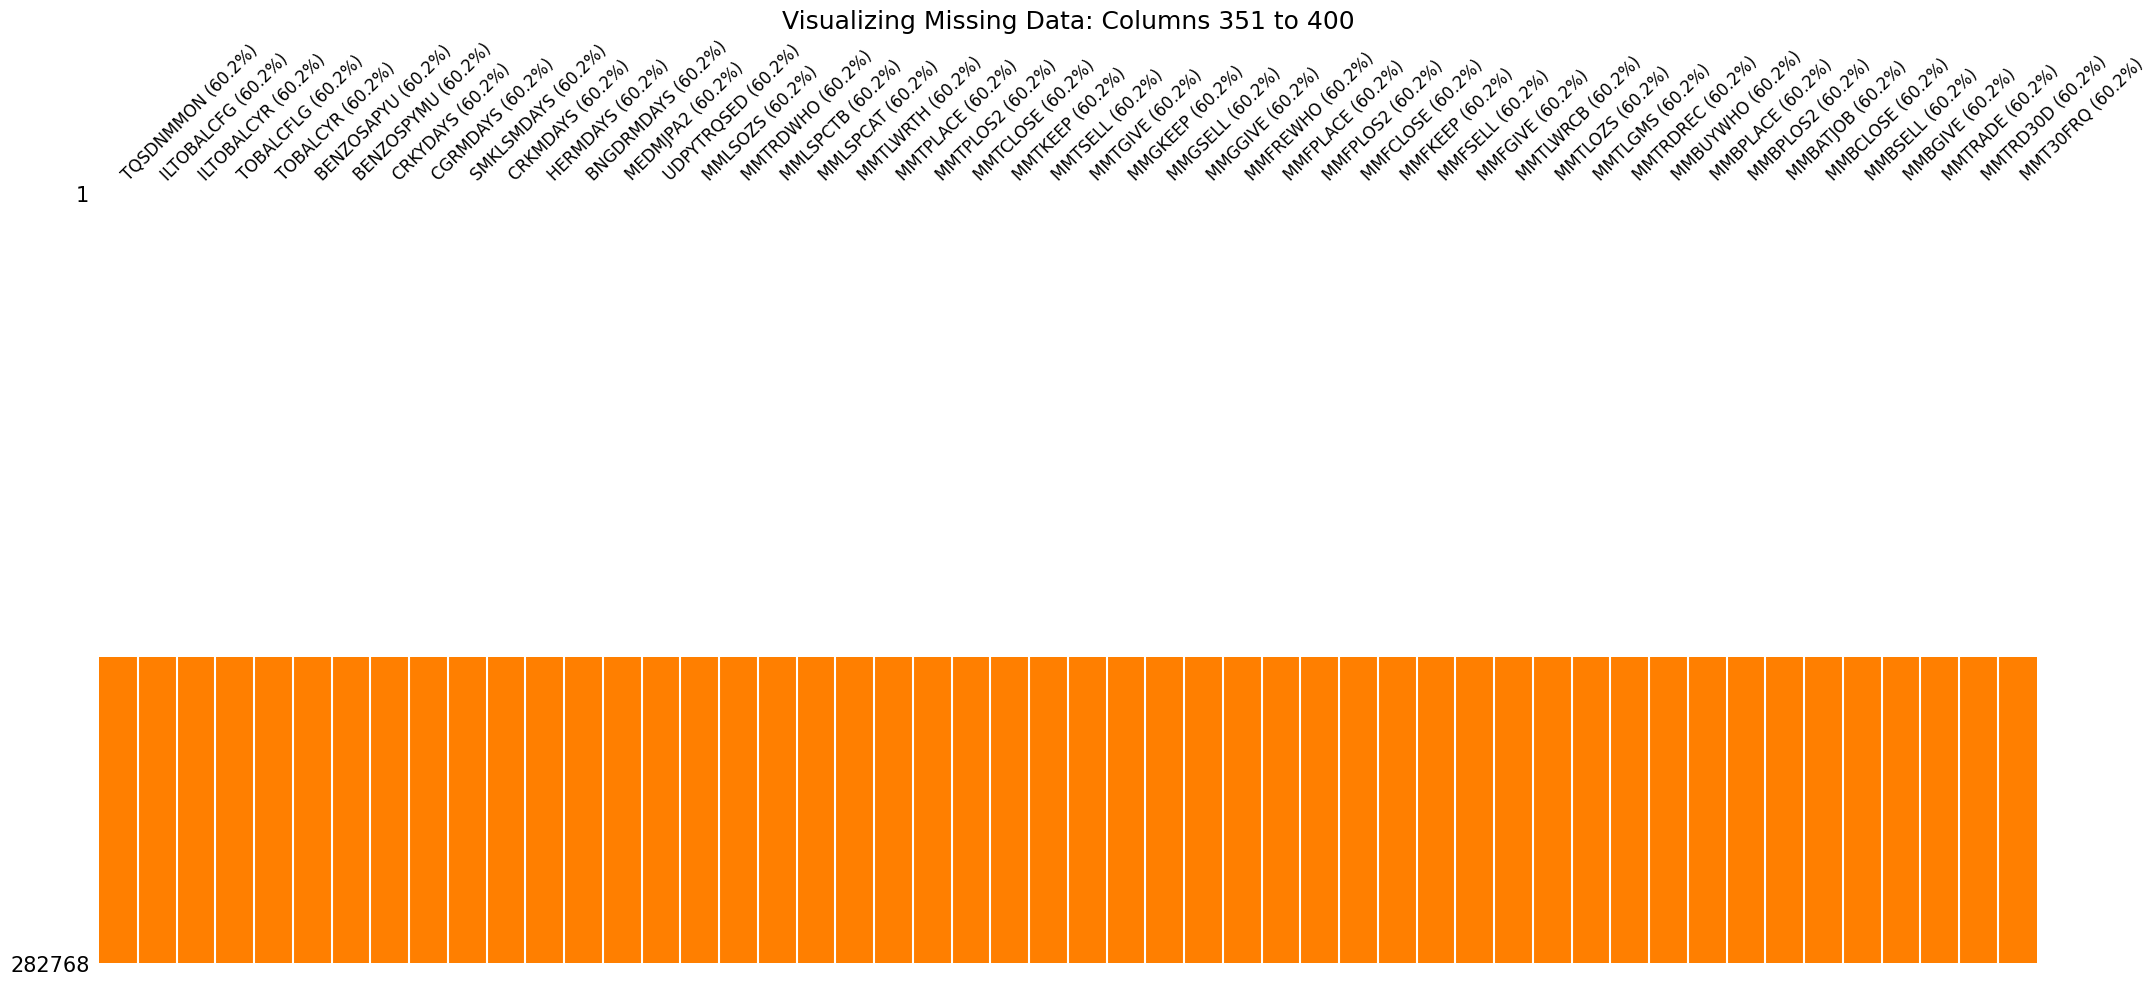

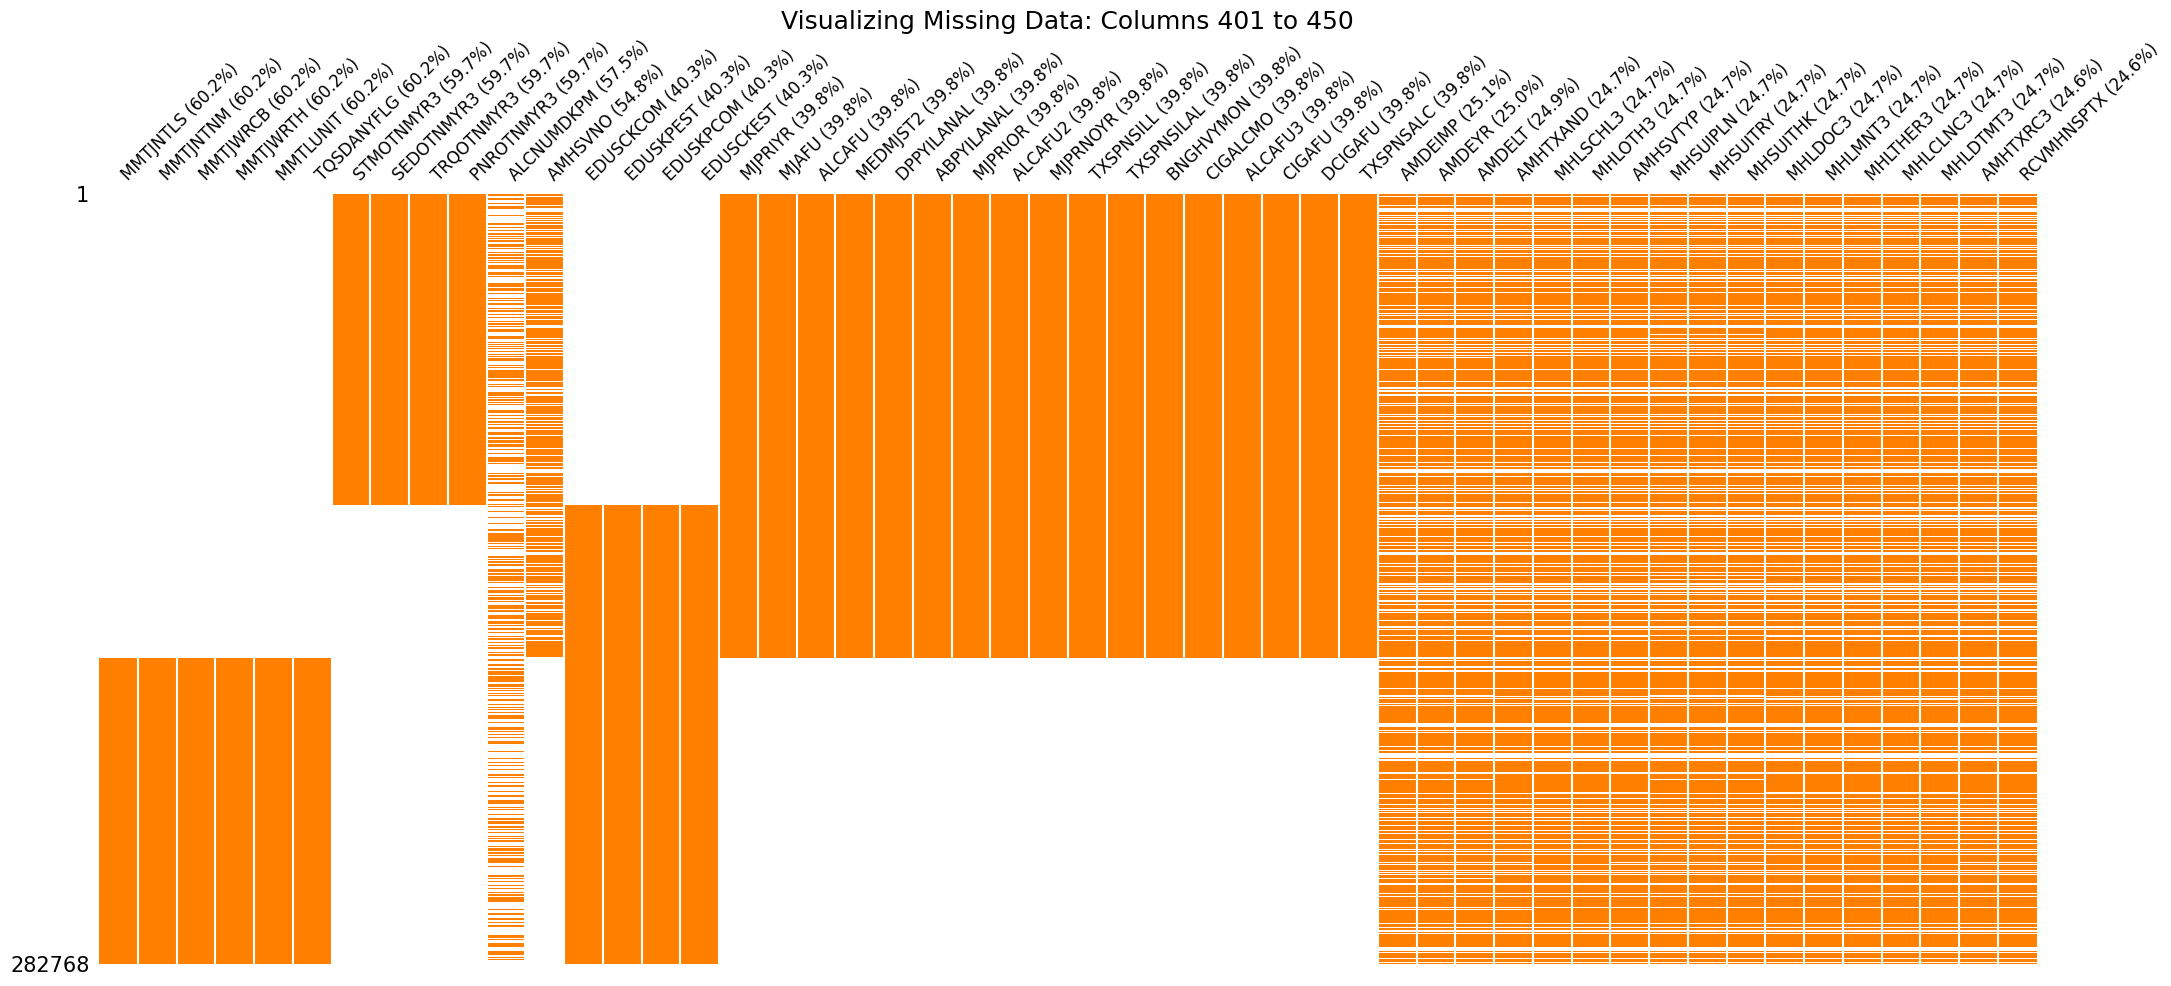

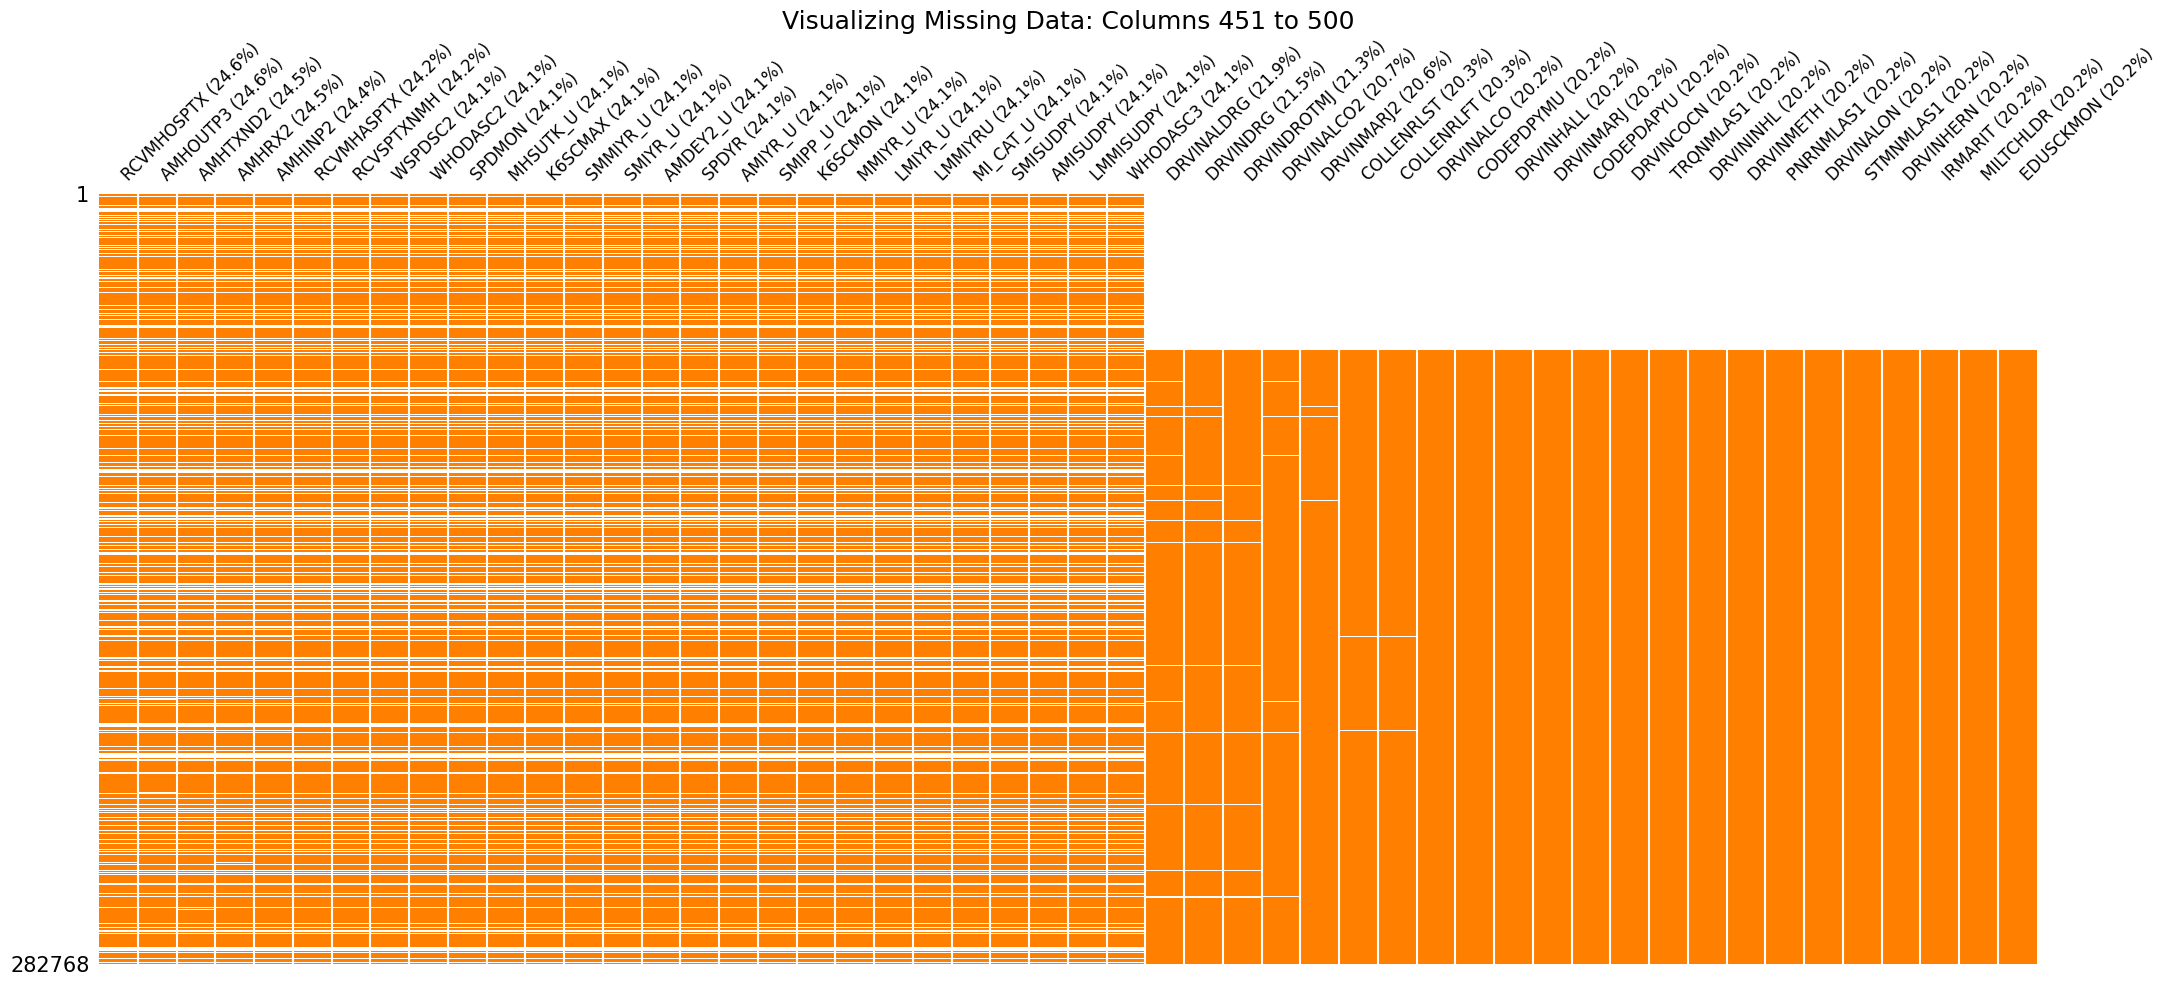

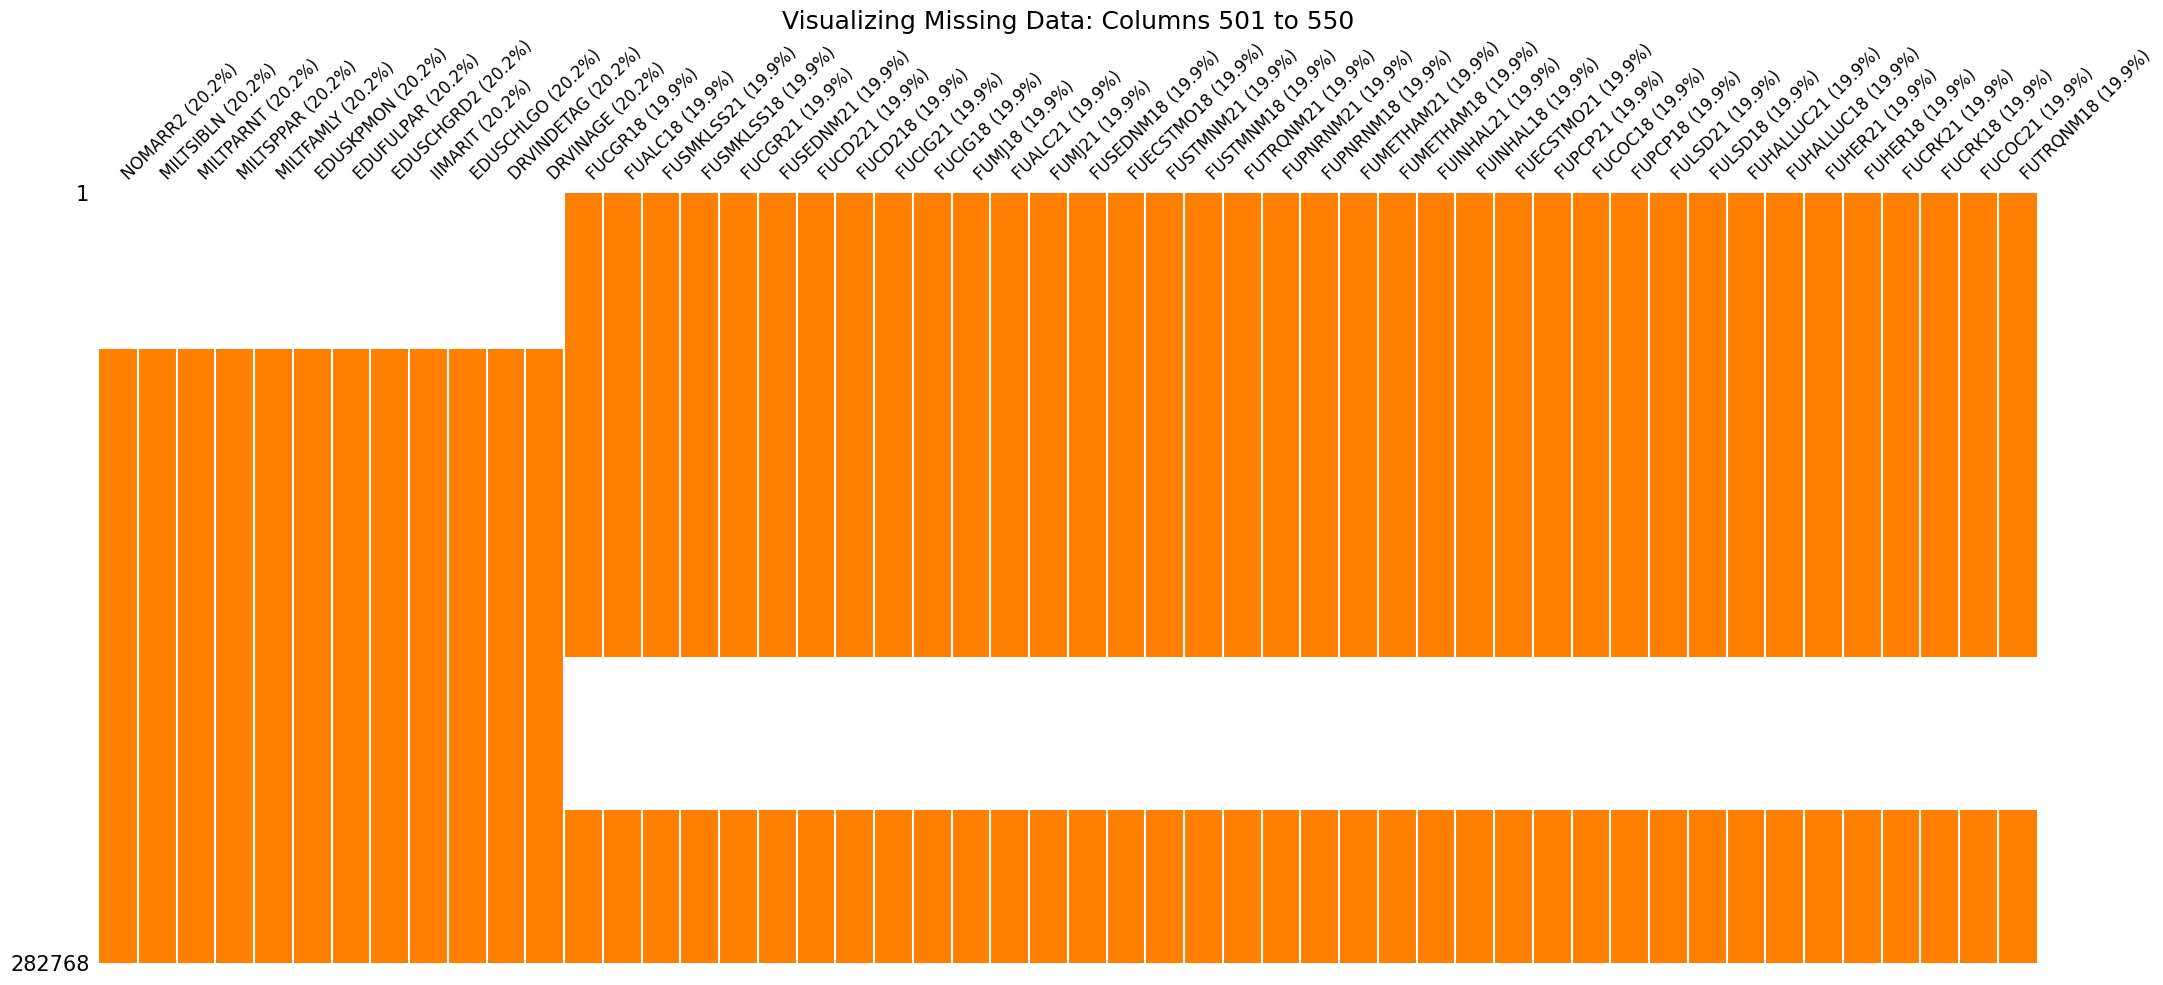

In [300]:


def visualize_missing_columns_in_chunks(df: pd.DataFrame, threshold: float = 20.0, chunk_size: int = 50) -> None:
    """
    Visualizes the missing values for columns that have more than the given percentage of missing data using `msno.matrix`,
    iterating over the columns in chunks, and customizes the color to orange with missing percentages in column names.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    threshold (float): The percentage threshold to filter columns. Default is 20%.
    chunk_size (int): The number of columns to visualize per iteration. Default is 50.
    """
    # Calculate the percentage of missing values for each column
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    
    # Filter columns that have more than the specified percentage of missing values
    columns_with_missing = missing_percentage[missing_percentage > threshold].sort_values(ascending=False)
    
    # Create a dictionary to rename the columns by adding the missing percentage to the name
    renamed_columns = {col: f"{col} ({missing_percentage[col]:.1f}%)" for col in columns_with_missing.index}
    
    # Create a DataFrame copy with renamed columns for those with missing values above the threshold
    df_with_missing_renamed = df[columns_with_missing.index].rename(columns=renamed_columns)
    
    # Determine the number of iterations needed
    num_chunks = math.ceil(len(columns_with_missing) / chunk_size)
    
    # Iterate and visualize columns in chunks
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(columns_with_missing))
        
        # Get the subset of renamed columns for the current chunk
        chunk_columns = list(renamed_columns.values())[start_idx:end_idx]
        
        # Use msno.matrix directly without plt.figure() to suppress the figure message
        msno.matrix(df_with_missing_renamed[chunk_columns], fontsize=12, sparkline=False, color=(1.0, 0.5, 0.0))  # RGB color for orange
        
        # Add a title showing the range of columns being visualized and set a bigger font size
        plt.title(f"Visualizing Missing Data: Columns {start_idx + 1} to {end_idx}", fontsize=18)  # Adjusted title size
        
        # Display the plot
        plt.show()


visualize_missing_columns_in_chunks(df, threshold=10.0, chunk_size=50)


### Observations from `msno.matrix()` Visualization

- **High Missing Values**: 
  - There are **1,458 columns** with more than **10% missing values**.
  
- **Patterns of Missingness**: 
  - We can observe clear patterns of missing data where **certain columns have data present in earlier years but are missing in later years**, and conversely, **some columns are missing in earlier years but have data available in later years**. 
  - This indicates that the missingness is **non-random** and could be related to the **time period** or changes in data collection processes over time.
  
- **Next Steps**:
  - Consider potential imputation strategies, especially for time-based patterns.
  - If necessary, drop columns with high missing percentages or those that do not contribute significantly to the analysis.
